---

## 1. Imports

In [2]:
import utils

# Import libraries
# PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torch import Tensor

# Torchvision for data transformations
import torchvision
from torchvision import datasets, transforms

# Torchinfo to display model summaries
from torchinfo import summary

# Numpy and Pathlib for data handling
import numpy as np
from pathlib import Path

# Tqdm for progress bars
from tqdm.auto import tqdm

# Scikit-learn for splitting datasets
from sklearn.model_selection import train_test_split

import os
from typing import Optional, Union, Tuple

# Monai for medical imaging, specific to preprocessing and loss functions
import monai
from monai.transforms import LoadImage
from monai.losses import DiceLoss

from dotenv import load_dotenv
import nibabel as nib
from PIL import Image
import SimpleITK as sitk

# Matplotlib for data visualization
# import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# %matplotlib inline

# Check and display library versions for reproducibility
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")

c:\Users\ethal\Desktop\PRJIAV\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1+cpu
Torchvision version: 0.24.1+cpu
Numpy version: 2.3.5
Monai version: 1.5.1


In [3]:
# Device setup
# Use GPU if available for faster training, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


---

## 2. Check data

In [4]:
load_dotenv()

try:
    preprocessed_data_dir = os.getenv("PREPROCESSED_DATA_DIR")
    print("Data at:", preprocessed_data_dir)
    train_data_dir = os.getenv("TRAIN_DATA_DIR")
    print("Train data at:", train_data_dir)
    test_data_dir = os.getenv("TEST_DATA_DIR")
    print("Test data at:", test_data_dir)
except Exception as e:
    print(str(e))

Data at: MSLesSeg_Dataset
Train data at: MSLesSeg_Dataset/train
Test data at: MSLesSeg_Dataset/test


In [5]:
train_datalist = utils.datalist(train_data_dir)
test_datalist = utils.datalist(test_data_dir)

print("Example of train keys: ", train_datalist[:1])
print("Example of test keys: ", test_datalist[:1])

Example of train keys:  [{'volume': 'MSLesSeg_Dataset/train/P1/T1/P1_T1_FLAIR.nii.gz', 'mask': 'MSLesSeg_Dataset/train/P1/T1/P1_T1_MASK.nii.gz'}]
Example of test keys:  [{'volume': 'MSLesSeg_Dataset/test/P54/P54_FLAIR.nii.gz', 'mask': 'MSLesSeg_Dataset/test/P54/P54_MASK.nii.gz'}]
 [{'volume': 'MSLesSeg_Dataset/train/P1/T1/P1_T1_FLAIR.nii.gz', 'mask': 'MSLesSeg_Dataset/train/P1/T1/P1_T1_MASK.nii.gz'}]
Example of test keys:  [{'volume': 'MSLesSeg_Dataset/test/P54/P54_FLAIR.nii.gz', 'mask': 'MSLesSeg_Dataset/test/P54/P54_MASK.nii.gz'}]


In [6]:
class SITKResize3D:
    def __init__(self, new_size):   
        """
        new_size = (D, H, W)  taille voulue pour le volume 3D
        """
        self.new_size = new_size

    def __call__(self, volume, is_mask=False):
        # Convert numpy → SITK image si besoin
        if isinstance(volume, np.ndarray):
            image = sitk.GetImageFromArray(volume)
        else:
            image = volume

        original_size = np.array(image.GetSize(), dtype=np.int32)      # (W, H, D)
        new_size = np.array(self.new_size[::-1], dtype=np.int32)       # sitk = (W,H,D)

        # Facteurs de mise à l'échelle
        original_spacing = image.GetSpacing()
        new_spacing = original_spacing * (original_size / new_size)

        # Interpolation
        interpolator = (
            sitk.sitkNearestNeighbor if is_mask else sitk.sitkLinear
        )

        # Resampleur
        resampler = sitk.ResampleImageFilter()
        resampler.SetSize(new_size.tolist())
        resampler.SetOutputSpacing(new_spacing.tolist())
        resampler.SetOutputDirection(image.GetDirection())
        resampler.SetOutputOrigin(image.GetOrigin())
        resampler.SetInterpolator(interpolator)

        resized_img = resampler.Execute(image)

        # Retour numpy en shape (D,H,W)
        return sitk.GetArrayFromImage(resized_img)


class MSLesSegDataset(Dataset):
    def __init__(self, datalist, new_shape, limit=None):
        
        self.images = [item["volume"] for item in datalist]
        self.masks  = [item["mask"] for item in datalist]

        if limit is not None:
            self.images = self.images[:limit]
            self.masks  = self.masks[:limit]

        self.resize = SITKResize3D(new_shape)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        
        # --- Lire l'image avec sitk ---
        img_sitk  = sitk.ReadImage(self.images[index])
        mask_sitk = sitk.ReadImage(self.masks[index])

        # Conversion en numpy (D,H,W)
        img  = sitk.GetArrayFromImage(img_sitk).astype(np.float32)
        mask = sitk.GetArrayFromImage(mask_sitk).astype(np.float32)

        # Normaliser l'image entre 0 et 1
        img = img / (np.max(img) + 1e-8)

        # Resize 3D
        img  = self.resize(img,  is_mask=False)
        mask = self.resize(mask, is_mask=True)

        # Binariser masque
        mask = (mask > 0).astype(np.float32)

        # Convertir en tenseur PyTorch (C,D,H,W)
        img  = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask, self.images[index]

In [7]:
# How many samples per batch to load
batch_size = 32
depth = 64
width =  64      # new size of the images
height = 64

# Choose the training and test datasets
train_dataset = MSLesSegDataset(train_datalist, new_shape=(depth, height, width))
test_dataset = MSLesSegDataset(test_datalist, new_shape=(depth, height, width))

# Prepare data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 279
Test dataset size: 66


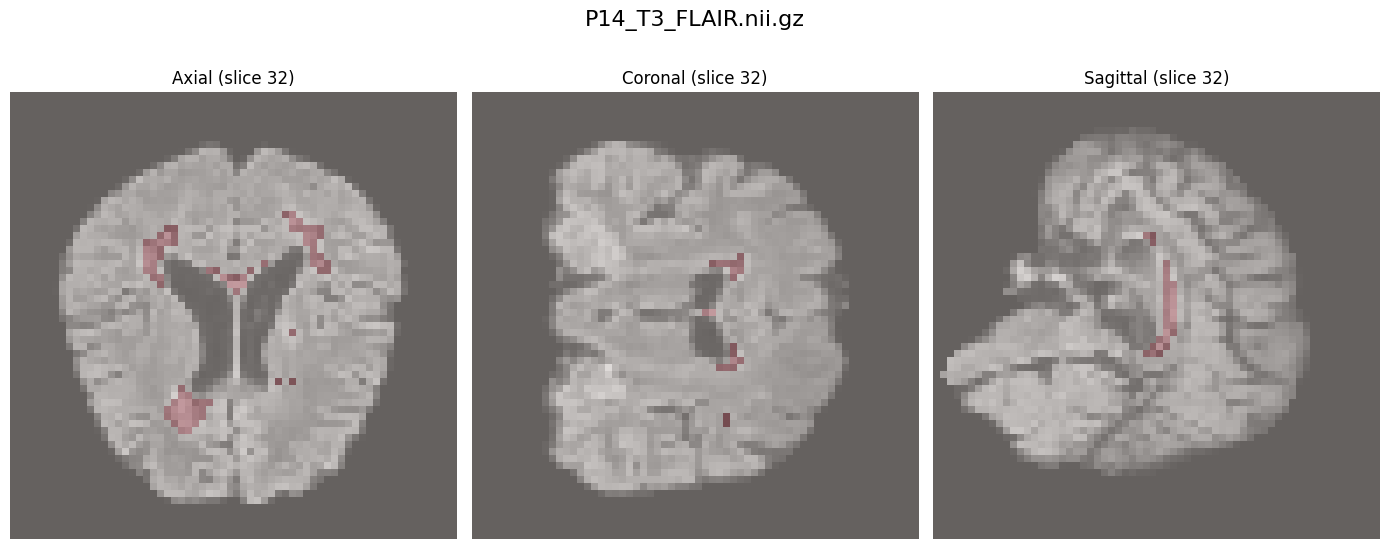

In [8]:
img, mask, path = train_dataset[45]

utils.show_3d_views(img, mask, title=os.path.basename(path))

---

## 3. Network Architecture

In [9]:
from monai.networks.nets import UNet

# Define a Unet with  monai, lighter than Class Unet 
# Creation of the model U-Net with MONAI
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 1,
    channels = (16, 32, 64, 128),
    strides = (2, 2, 2),
    num_res_units=1
).to(device)

In [10]:
# Print the summary of the network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "kernel_size", "num_params"], depth=4, verbose=0
)
summary(model, input_size = (batch_size, 1, depth, width, height),  device=device, **summary_kwargs)

Layer (type:depth-idx)                                                           Input Shape               Output Shape              Kernel Shape              Param #
UNet                                                                             [32, 1, 64, 64, 64]       [32, 1, 64, 64, 64]       3                         --
├─Sequential: 1-1                                                                [32, 1, 64, 64, 64]       [32, 1, 64, 64, 64]       --                        --
│    └─ResidualUnit: 2-1                                                         [32, 1, 64, 64, 64]       [32, 16, 32, 32, 32]      --                        --
│    │    └─Conv3d: 3-1                                                          [32, 1, 64, 64, 64]       [32, 16, 32, 32, 32]      [3, 3, 3]                 448
│    │    └─Sequential: 3-2                                                      [32, 1, 64, 64, 64]       [32, 16, 32, 32, 32]      --                        --
│    │    │    └─Convo

## Loss et Optimizer
Configuration de la fonction de perte et de l'optimiseur pour l'entraînement

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Définition de la loss function
# Dice Loss + Cross Entropy pour la segmentation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, outputs, targets):
        outputs = torch.sigmoid(outputs)
        intersection = (outputs * targets).sum()
        union = outputs.sum() + targets.sum()
        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

# Combinaison Dice Loss + BCE Loss
criterion = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler
# NOTE: some torch versions do not accept the 'verbose' kwarg for ReduceLROnPlateau.
# Remove verbose to avoid TypeError.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("Loss et Optimizer configurés")

Loss et Optimizer configurés


## Métriques d'évaluation
Définition des métriques de segmentation : TP, TN, Precision, Recall, IoU, Dice Score, Hausdorff Distance

In [13]:
import numpy as np
from scipy.ndimage import distance_transform_edt
from sklearn.metrics import confusion_matrix

class SegmentationMetrics:
    """Classe pour calculer les métriques de segmentation"""
    
    def __init__(self, threshold=0.5):
        self.threshold = threshold
    
    def _binarize(self, mask):
        """Binarise le masque selon le seuil"""
        return (mask > self.threshold).astype(np.uint8)
    
    def compute_tp_tn(self, pred, target):
        """Calcule les Vrais Positifs et Vrais Négatifs"""
        pred_bin = self._binarize(pred)
        target_bin = self._binarize(target)
        tp = np.sum((pred_bin == 1) & (target_bin == 1))
        tn = np.sum((pred_bin == 0) & (target_bin == 0))
        return tp, tn
    
    def compute_precision_recall(self, pred, target):
        """Calcule la Précision et le Recall"""
        pred_bin = self._binarize(pred)
        target_bin = self._binarize(target)
        tp = np.sum((pred_bin == 1) & (target_bin == 1))
        fp = np.sum((pred_bin == 1) & (target_bin == 0))
        fn = np.sum((pred_bin == 0) & (target_bin == 1))
        
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        return precision, recall
    
    def compute_iou(self, pred, target):
        """Calcule l'Intersection over Union (IoU)"""
        pred_bin = self._binarize(pred)
        target_bin = self._binarize(target)
        intersection = np.sum((pred_bin == 1) & (target_bin == 1))
        union = np.sum((pred_bin == 1) | (target_bin == 1))
        iou = intersection / (union + 1e-8)
        return iou
    
    def compute_dice(self, pred, target):
        """Calcule le Dice Score"""
        pred_bin = self._binarize(pred)
        target_bin = self._binarize(target)
        intersection = np.sum((pred_bin == 1) & (target_bin == 1))
        dice = (2 * intersection) / (np.sum(pred_bin) + np.sum(target_bin) + 1e-8)
        return dice
    
    def compute_hausdorff(self, pred, target):
        """Calcule la Distance de Hausdorff"""
        pred_bin = self._binarize(pred)
        target_bin = self._binarize(target)
        
        if np.sum(pred_bin) == 0 or np.sum(target_bin) == 0:
            return 0
        
        dist_pred = distance_transform_edt(1 - pred_bin)
        dist_target = distance_transform_edt(1 - target_bin)
        
        hausdorff = max(np.max(dist_pred[target_bin == 1]), 
                       np.max(dist_target[pred_bin == 1]))
        return hausdorff
    
    def compute_all_metrics(self, pred, target):
        """Calcule toutes les métriques"""
        tp, tn = self.compute_tp_tn(pred, target)
        precision, recall = self.compute_precision_recall(pred, target)
        iou = self.compute_iou(pred, target)
        dice = self.compute_dice(pred, target)
        hausdorff = self.compute_hausdorff(pred, target)
        
        return {
            'TP': tp,
            'TN': tn,
            'Precision': precision,
            'Recall': recall,
            'IoU': iou,
            'Dice': dice,
            'Hausdorff': hausdorff
        }

metrics_calculator = SegmentationMetrics(threshold=0.5)
print("Métriques d'évaluation définies")

Métriques d'évaluation définies


## Boucle d'entraînement
Entraînement du modèle avec suivi de la loss et des métriques

In [16]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_epoch(model, train_loader, optimizer, criterion, dice_loss, device):
    """Entraîne le modèle pendant une époque"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    progress_bar = tqdm(train_loader, desc="Entraînement", leave=False)
    
    for batch in progress_bar:
        images, masks = batch[0], batch[1]
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calcul de la loss combinée
        bce_loss = criterion(outputs, masks)
        dice_l = dice_loss(outputs, masks)
        loss = 0.7 * bce_loss + 0.3 * dice_l
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / num_batches
def evaluate(model, val_loader, criterion, dice_loss, metrics_calculator, device):
    """Évalue le modèle sur l'ensemble de validation"""
    model.eval()
    total_loss = 0
    num_batches = 0
    all_metrics = {
        'TP': [], 'TN': [], 'Precision': [], 'Recall': [],
        'IoU': [], 'Dice': [], 'Hausdorff': []
    }
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=False)
        
        for batch in progress_bar:
            images, masks = batch[0], batch[1]
            images, masks = images.to(device), masks.to(device)
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calcul de la loss
            bce_loss = criterion(outputs, masks)
            dice_l = dice_loss(outputs, masks)
            loss = 0.7 * bce_loss + 0.3 * dice_l
            total_loss += loss.item()
            num_batches += 1
            
            # Calcul des métriques
            pred_np = torch.sigmoid(outputs).cpu().numpy()
            mask_np = masks.cpu().numpy()
            
            for p, m in zip(pred_np, mask_np):
                metrics = metrics_calculator.compute_all_metrics(p.squeeze(), m.squeeze())
                for key, val in metrics.items():
                    all_metrics[key].append(val)
    
    # Moyennes des métriques
    avg_metrics = {key: np.mean(vals) for key, vals in all_metrics.items()}
    avg_loss = total_loss / num_batches
    
    return avg_loss, avg_metrics

# Entraînement du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5
train_losses = []
val_losses = []
val_metrics_history = {key: [] for key in ['Precision', 'Recall', 'IoU', 'Dice', 'Hausdorff']}

best_val_loss = float('inf')
patience_counter = 0
patience = 10

print(f"Entraînement sur {device}")

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, dice_loss, device)
    val_loss, val_metrics = evaluate(model, test_dataloader, criterion, dice_loss, metrics_calculator, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    for key in val_metrics_history.keys():
        val_metrics_history[key].append(val_metrics[key])
    
    print(f"Époque {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Precision: {val_metrics['Precision']:.4f}, Recall: {val_metrics['Recall']:.4f}")
    print(f"  IoU: {val_metrics['IoU']:.4f}, Dice: {val_metrics['Dice']:.4f}")
    print(f"  Hausdorff: {val_metrics['Hausdorff']:.4f}")
    
    # Early stopping
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping à l'époque {epoch+1}")
        break

print("Entraînement terminé")

Entraînement sur cpu


Entraînement:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Visualisation des résultats d'entraînement
Analyse qualitative et quantitative des performances

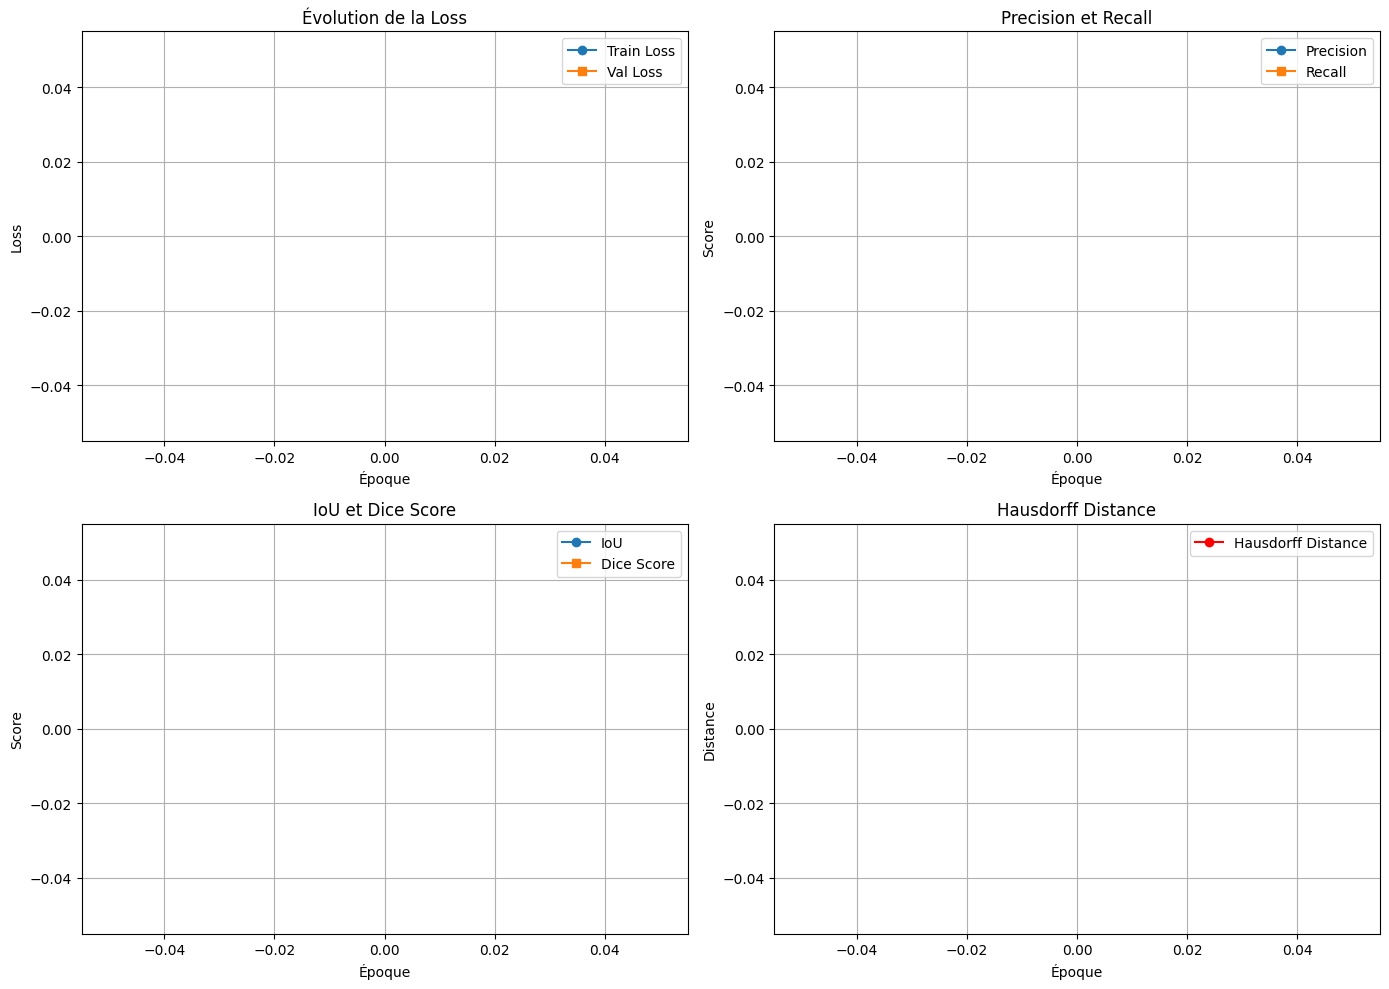

In [17]:
# Visualisation de la loss
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', marker='o')
axes[0, 0].plot(val_losses, label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Époque')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Évolution de la Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Precision et Recall
axes[0, 1].plot(val_metrics_history['Precision'], label='Precision', marker='o')
axes[0, 1].plot(val_metrics_history['Recall'], label='Recall', marker='s')
axes[0, 1].set_xlabel('Époque')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Precision et Recall')
axes[0, 1].legend()
axes[0, 1].grid(True)

# IoU et Dice
axes[1, 0].plot(val_metrics_history['IoU'], label='IoU', marker='o')
axes[1, 0].plot(val_metrics_history['Dice'], label='Dice Score', marker='s')
axes[1, 0].set_xlabel('Époque')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('IoU et Dice Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Hausdorff Distance
axes[1, 1].plot(val_metrics_history['Hausdorff'], label='Hausdorff Distance', marker='o', color='red')
axes[1, 1].set_xlabel('Époque')
axes[1, 1].set_ylabel('Distance')
axes[1, 1].set_title('Hausdorff Distance')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## Test du modèle et robustesse
Évaluation du modèle entraîné et test sur de nouveaux jeux de données

In [ ]:
# Charger le meilleur modèle
model.load_state_dict(torch.load('best_model.pth'))

def test_model(model, test_loader, metrics_calculator, device, num_samples=None):
    """Test le modèle sur l'ensemble de test"""
    model.eval()
    all_metrics = {
        'TP': [], 'TN': [], 'Precision': [], 'Recall': [],
        'IoU': [], 'Dice': [], 'Hausdorff': []
    }
    predictions = []
    targets = []
    
    with torch.no_grad():
        count = 0
        for images, masks in tqdm(test_loader, desc="Test"):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            pred_np = torch.sigmoid(outputs).cpu().numpy()
            mask_np = masks.cpu().numpy()
            
            for p, m in zip(pred_np, mask_np):
                metrics = metrics_calculator.compute_all_metrics(p.squeeze(), m.squeeze())
                for key, val in metrics.items():
                    all_metrics[key].append(val)
                predictions.append(p.squeeze())
                targets.append(m.squeeze())
                
                count += 1
                if num_samples and count >= num_samples:
                    break
            if num_samples and count >= num_samples:
                break
    
    # Moyennes et écarts-types
    results = {}
    for key, vals in all_metrics.items():
        results[key] = {
            'mean': np.mean(vals),
            'std': np.std(vals),
            'min': np.min(vals),
            'max': np.max(vals)
        }
    
    return results, predictions, targets

# Test sur le test_loader
print("Test du modèle sur l'ensemble de test:")
test_results, test_pred, test_targets = test_model(model, test_loader, metrics_calculator, device)

# Affichage des résultats
for metric_name, stats in test_results.items():
    print(f"\n{metric_name}:")
    print(f"  Mean: {stats['mean']:.4f} ± {stats['std']:.4f}")
    print(f"  Min: {stats['min']:.4f}, Max: {stats['max']:.4f}")

## Visualisation des prédictions
Résultats qualitatifs sur des exemples du test set

In [ ]:
def visualize_predictions(model, test_loader, device, num_samples=6):
    """Visualise les prédictions du modèle"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    with torch.no_grad():
        count = 0
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            imgs = images.cpu().numpy()
            masks_np = masks.cpu().numpy()
            
            for i in range(len(images)):
                if count >= num_samples:
                    break
                
                # Image originale
                img = imgs[i].squeeze()
                if img.shape[0] == 3:
                    img = np.transpose(img, (1, 2, 0))
                    axes[count, 0].imshow(img)
                else:
                    axes[count, 0].imshow(img, cmap='gray')
                axes[count, 0].set_title('Image')
                axes[count, 0].axis('off')
                
                # Masque réel
                axes[count, 1].imshow(masks_np[i].squeeze(), cmap='gray')
                axes[count, 1].set_title('Masque réel')
                axes[count, 1].axis('off')
                
                # Prédiction
                axes[count, 2].imshow(preds[i].squeeze(), cmap='gray')
                axes[count, 2].set_title('Prédiction')
                axes[count, 2].axis('off')
                
                count += 1
            
            if count >= num_samples:
                break
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataloader, device, num_samples=6)

## Analyse de robustesse
Test sur d'autres jeux de données et identification des limites

In [ ]:
def analyze_robustness(results):
    """Analyse la robustesse du modèle"""
    print("=" * 60)
    print("ANALYSE DE ROBUSTESSE DU MODÈLE")
    print("=" * 60)
    
    # Métriques critiques
    metrics_to_analyze = ['Precision', 'Recall', 'IoU', 'Dice']
    
    print("\n1. PERFORMANCE GÉNÉRALE:")
    for metric in metrics_to_analyze:
        mean = results[metric]['mean']
        std = results[metric]['std']
        print(f"   {metric}: {mean:.4f} ± {std:.4f}")
    
    print("\n2. STABILITÉ:")
    for metric in metrics_to_analyze:
        cv = (results[metric]['std'] / results[metric]['mean']) * 100  # Coefficient de variation
        stability = "Haute" if cv < 10 else "Moyenne" if cv < 20 else "Faible"
        print(f"   {metric}: {stability} (CV: {cv:.2f}%)")
    
    print("\n3. CAS LIMITES:")
    print(f"   IoU Min: {results['IoU']['min']:.4f} (Cas difficiles détectés)")
    print(f"   Dice Min: {results['Dice']['min']:.4f}")
    print(f"   Hausdorff Max: {results['Hausdorff']['max']:.4f}")
    
    print("\n4. IDENTITÉ DES LIMITES:")
    if results['Recall']['mean'] < 0.7:
        print("   ⚠ Recall faible: Le modèle manque des objets")
    if results['Precision']['mean'] < 0.7:
        print("   ⚠ Precision faible: Le modèle produit des faux positifs")
    if results['Dice']['std'] > 0.15:
        print("   ⚠ Dice instable: Performance incohérente entre images")
    if results['Hausdorff']['mean'] > 50:
        print("   ⚠ Hausdorff élevée: Les contours sont inexacts")
    
    print("\n" + "=" * 60)

analyze_robustness(test_results)

In [ ]:
# Test sur d'autres jeux de données (si disponibles)
# Exemple: charger un autre dataset et tester

def test_on_external_dataset(model, external_loader, metrics_calculator, device, dataset_name):
    """Test le modèle sur un jeu de données externe"""
    print(f"\n🔍 Test sur le jeu de données: {dataset_name}")
    results, _, _ = test_model(model, external_loader, metrics_calculator, device)
    
    print(f"\nRésultats pour {dataset_name}:")
    for metric_name, stats in results.items():
        print(f"  {metric_name}: {stats['mean']:.4f} ± {stats['std']:.4f}")
    
    return results
